In [1]:
from data_processing import *
from model import *

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
# import torchvision
from torch.utils.data import Dataset, DataLoader

# import matplotlib.pyplot as plt
# from datetime import datetime
# import time
import os.path
from sklearn.metrics import r2_score

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print('On GPU') if device == torch.device("cuda:0") else print('On CPU')

On CPU


In [4]:
class Hyperparameter:
    num_predictions: int    = 6

    # hyperparams
    batch_size: int         = 32
    num_epochs: int         = 8
    train_test_split: float = 0.9

    # bookkeeping
    batch_report_gap: int   = 96
    sav_model_epoch: bool   = True
    vals_per_epoch: int     = 3

    # optimizer
    learning_rate: float    = 0.0005
    lr_decay: float         = 0.9

hp = Hyperparameter()

# data processing garbage

In [5]:
dp = DataProcessor()

X_IMG_IDS, X_CLEANED, Y_CLEANED = dp.get_and_process_train_data()
X_EVAL_IMG_IDS, X_EVAL_NORMALISED = dp.get_and_process_eval_data()

TRAIN_IMG_DIR = os.path.join('data', 'train_images')
EVAL_IMG_DIR = os.path.join('data', 'test_images')

X = np.array(X_CLEANED, dtype=np.float32)#[:1000]
Y = np.array(Y_CLEANED, dtype=np.float32)#[:1000]
TRAIN_TEST_SPLIT = int(np.round(hp.train_test_split * len(X)))

TRAIN_IMG_ID = X_IMG_IDS[:TRAIN_TEST_SPLIT]
TRAIN_X = X[:TRAIN_TEST_SPLIT]
TRAIN_Y = Y[:TRAIN_TEST_SPLIT]
TRAIN_DATASET = CustomDataset(TRAIN_IMG_ID, TRAIN_X, TRAIN_Y, img_dir=TRAIN_IMG_DIR, transform=augment_transform)
TRAIN_DATALOADER = DataLoader(TRAIN_DATASET, batch_size=hp.batch_size, shuffle=True)

TEST_IMG_ID = X_IMG_IDS[TRAIN_TEST_SPLIT:].reset_index(drop=True)
TEST_X = X[TRAIN_TEST_SPLIT:]
TEST_Y = Y[TRAIN_TEST_SPLIT:]
TEST_DATASET = CustomDataset(TEST_IMG_ID, TEST_X, TEST_Y, img_dir=TRAIN_IMG_DIR, transform=standard_transform)
TEST_DATALOADER = DataLoader(TEST_DATASET, batch_size=hp.batch_size, shuffle=False)

EVAL_X = np.array(X_EVAL_NORMALISED, dtype=np.float32)
EVAL_Y = np.zeros((6391,6), dtype=np.float32) # empty
EVAL_DATASET = CustomDataset(X_EVAL_IMG_IDS, EVAL_X, EVAL_Y, img_dir=EVAL_IMG_DIR, transform=standard_transform)
EVAL_DATALOADER = DataLoader(EVAL_DATASET, batch_size=hp.batch_size, shuffle=False)

print(TRAIN_X.shape, TRAIN_Y.shape, len(TRAIN_DATALOADER))
print(TEST_X.shape, TEST_Y.shape, len(TEST_DATALOADER))
print(EVAL_X.shape, EVAL_Y.shape, len(EVAL_DATALOADER))

# for i in Y_CLEANED.columns:
#     dp.hist(dp.train_data[i],bins=50)
#     dp.hist(Y_CLEANED[i])
#     dp.hist(dp.inv_transform_Y(Y_CLEANED)[i], bins=50)
#     print(min(Y_CLEANED[i]), max(Y_CLEANED[i]))

# r2_score(Y_CLEANED[TRAIN_TEST_SPLIT:], ) 


(36240, 163) (36240, 6) 1133
(4027, 163) (4027, 6) 126
(6391, 163) (6391, 6) 200


# MODEL

In [6]:
learn_rate = 0.001
learn_decay = 0.9

TRAIN_COLUMN_ORDER = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

In [7]:
model_to_load = None
# model_to_load = os.path.join('model_savs', 'smallboyv3.sav')
model = BigBoyV2()
if model_to_load:
    model.load_state_dict(torch.load(model_to_load))
model.eval()
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learn_rate, weight_decay=0.02)
lambda_lr = lambda step: learn_decay ** step
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)
criterion = nn.MSELoss()

bk = BookKeeper(batches_per_epoch=len(TRAIN_DATALOADER))

In [8]:
# for img, data, target in TRAIN_DATALOADER:
#     a = model(img, data)
#     print(a.shape)
#     break

In [9]:
def validate(test_dataloader):
    model.eval()

    test_loss = []
    acc_predictions = [] # hold onto predictions and targets for R2
    acc_targets = []

    with torch.no_grad():
        for images, data, target in test_dataloader:

            images = images.to(device)
            data = data.to(device)
            target = target.to(device)

            prediction = model(images, data)
            loss = criterion(prediction, target).item()
            test_loss.append(loss)

            acc_predictions.append(prediction)
            acc_targets.append(target)

    test_loss = np.mean(test_loss) # / len(test_dataloader)

    # calculate R2 of transformed Y
    acc_targets_cpu = [tensor.cpu().numpy() for tensor in acc_targets]
    acc_predictions_cpu = [tensor.cpu().numpy() for tensor in acc_predictions]
    targets = np.concatenate(acc_targets_cpu)
    predictions = np.concatenate(acc_predictions_cpu)
    transformed_r2 = r2_score(targets, predictions)

    try: # calculate R2 after inverse Y transform
        target_df = pd.DataFrame(targets, columns=TRAIN_COLUMN_ORDER)
        pred_df = pd.DataFrame(predictions, columns=TRAIN_COLUMN_ORDER)
        actual_target_df = dp.inv_transform_Y(target_df)
        actual_pred_df = dp.inv_transform_Y(pred_df)
        actual_r2 = r2_score(actual_target_df, actual_pred_df)
    except:
        actual_r2 = -1000

    return test_loss, transformed_r2, actual_r2

In [10]:
def train_one_epoch(train_dataloader, test_dataloader):
    model.train()

    running_loss = []

    for batch_idx, (images, data, target) in enumerate(train_dataloader):
        
        optimizer.zero_grad()

        images = images.to(device)
        data = data.to(device)
        target = target.to(device)

        prediction = model(images, data)
        loss = criterion(prediction, target)

        loss.backward()
        optimizer.step()

        bk.tick_batch(loss.item())
        running_loss.append(loss.item())

        # if batch_idx > len(train_dataloader)//3:
        #     break # just train on a third of shuffled data every epoch

    scheduler.step() # STEPPING SCHEDULER 3x PER EPOCH

    test_loss, transformed_r2, actual_r2 = validate(test_dataloader)
    train_loss = np.array(running_loss).mean()
    bk.tick_epoch(train_loss, test_loss, transformed_r2, actual_r2)

    bk.show_plots() # plot every epoch

    return train_loss, test_loss, transformed_r2, actual_r2

In [11]:
def predict(dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, data, _ in dataloader:
            images = images.to(device)
            data = data.to(device)
            
            prediction = model(images, data).detach().cpu().numpy()
            predictions.append(prediction) # X4,X11,X18,X26,X50,X3112

    all_predictions_np = np.concatenate(predictions, axis=0)
    df = pd.DataFrame(all_predictions_np, columns=TRAIN_COLUMN_ORDER)
    # df = df[['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']] # format to id,X4,X11,X18,X50,X26,X3112

    # final_df = pd.concat([img_id, df], axis=1)
    return df

def predict_with_imgid(img_id, dataloader):
    df = dp.inv_transform_Y(predict(dataloader))
    return pd.concat([img_id, df], axis=1)

# RUNNING THE MODEL

In [12]:
df = []

Epoch  0.00 Batch  200 0.8268267650353281 00:22:59
Epoch  0.00 Batch  400 0.7981523836270357 00:25:50
Epoch  0.00 Batch  600 0.7836622066416983 00:28:49
Epoch  0.00 Batch  800 0.7748223765741421 00:31:37
Epoch  0.00 Batch  1000 0.7688932480535122 00:34:27
### Epoch  1.00 | train_loss 0.7670838691077186 test_loss 0.7423838887895856 test_r2 0.1626719380067811 actual_r2 0.04886753444767276



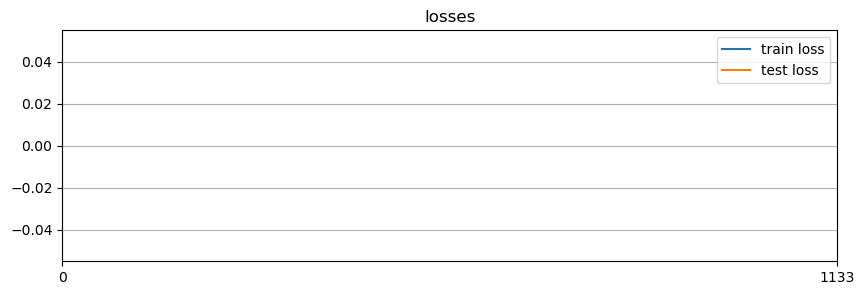

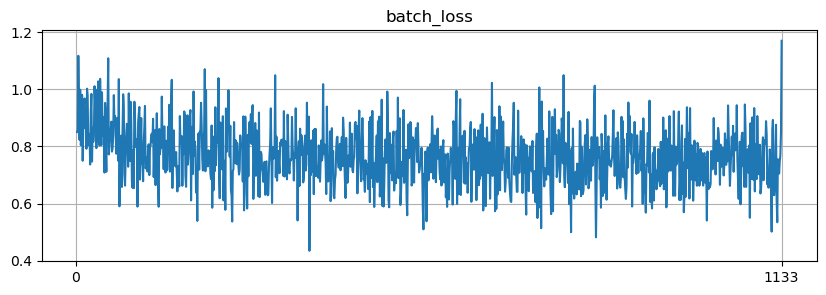

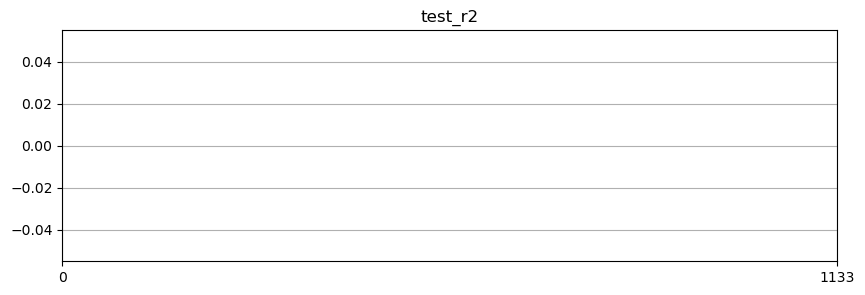

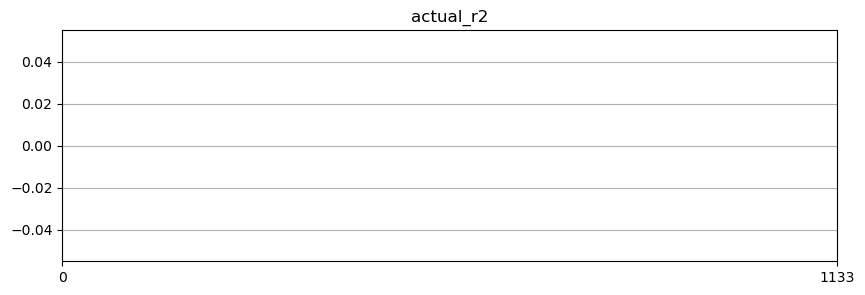

             id   X4_mean    X11_mean      X18_mean     X26_mean   X50_mean  \
0     154220505  1.068464  147.787864  19704.383334  3477.128057  14.880816   
1     195736552  1.031670  147.908826  19700.638953  3463.628581  14.891843   
2     182701773  0.949815  151.711690  19699.331456  3460.224881  14.793091   
3      27688500  1.009891  147.010008  19699.641006  3461.185495  15.039540   
4     195825045  0.971717  149.929398  19699.437619  3460.513691  14.866252   
...         ...       ...         ...           ...          ...        ...   
6386  195615880  0.964670  151.345904  19699.513518  3460.485323  14.734209   
6387  126224052  1.014800  147.199804  19699.743514  3461.352933  14.996856   
6388  178518157  1.055752  147.163824  19701.610972  3467.006584  14.948535   
6389  158746703  1.057089  147.649583  19702.419784  3469.833397  14.902572   
6390  104965612  0.980768  149.107355  19699.453380  3460.633717  14.928730   

         X3112_mean  
0     400940.060801  
1     3

In [13]:
epochs = 1

for e in range(epochs):
    _,_,_,r2 = train_one_epoch(TRAIN_DATALOADER, TEST_DATALOADER)
    pred = predict_with_imgid(X_EVAL_IMG_IDS, EVAL_DATALOADER)
    df.append((r2,pred))
    print(pred)

    if r2 > 0.15:
        filename = 'bigboyv2_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '.sav'
        torch.save(model.state_dict(), os.path.join('model_savs', filename))

In [14]:
prediction = df[-1][1]
# p = prediction.copy().rename(columns={'X4':'X4_mean', 'X11':'X11_mean', 'X18':'X18_mean', 'X26':'X26_mean', 'X50':'X50_mean', 'X3112':'X3112_mean'})
# p[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']] = dp.inv_transform_Y(p[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']])
# p = p[['id', 'X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']]
p = prediction.rename(columns={'X4_mean':'X4', 'X11_mean':'X11', 'X18_mean':'X18', 'X26_mean':'X26', 'X50_mean':'X50', 'X3112_mean':'X3112'})
print(p)
p.to_csv('tellmeitspositive.csv', index=False)

             id        X4         X11           X18          X26        X50  \
0     154220505  1.068464  147.787864  19704.383334  3477.128057  14.880816   
1     195736552  1.031670  147.908826  19700.638953  3463.628581  14.891843   
2     182701773  0.949815  151.711690  19699.331456  3460.224881  14.793091   
3      27688500  1.009891  147.010008  19699.641006  3461.185495  15.039540   
4     195825045  0.971717  149.929398  19699.437619  3460.513691  14.866252   
...         ...       ...         ...           ...          ...        ...   
6386  195615880  0.964670  151.345904  19699.513518  3460.485323  14.734209   
6387  126224052  1.014800  147.199804  19699.743514  3461.352933  14.996856   
6388  178518157  1.055752  147.163824  19701.610972  3467.006584  14.948535   
6389  158746703  1.057089  147.649583  19702.419784  3469.833397  14.902572   
6390  104965612  0.980768  149.107355  19699.453380  3460.633717  14.928730   

              X3112  
0     400940.060801  
1     3

In [15]:
catch

NameError: name 'catch' is not defined

In [ ]:
torch.save(model.state_dict(), os.path.join('model_savs', 'TESTSAVTIMM.sav'))

In [ ]:
loadmodel = BigBoyV2()

loadmodel.load_state_dict(torch.load(os.path.join('model_savs', 'TESTSAVTIMM.sav')))

<All keys matched successfully>

In [ ]:
for img, data, target in TRAIN_DATALOADER:
    loadmodel(img,data)
    break

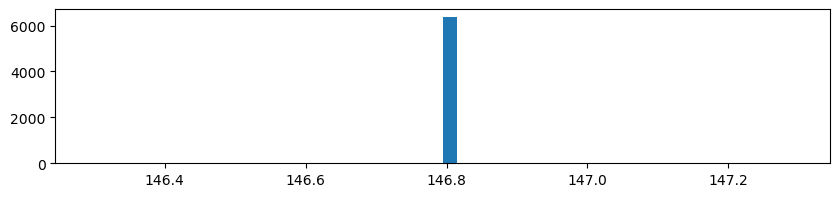

In [ ]:
dp.hist(df[-1][1]['X11_mean'])

In [ ]:
catch

NameError: name 'catch' is not defined

In [ ]:
# model_to_load = None
# # model_to_load = os.path.join('model_savs', 'smallboyv3.sav')

# model = Model(device=device, batches_per_epoch=len(TRAIN_DATALOADER), dataprocessor=dp)
# if model_to_load:
#     model.load_state_dict(torch.load(os.path.join('model_savs', 'smallboyv3.sav')))
# model.eval()
# model.to(device)

# df = []

In [ ]:
# training loop needs to be moved out 
# can keep the actual model definitions outside, but the loop needs to be in, i think smth smells funky

In [ ]:
# epochs = 21

# for e in range(epochs):
#     _,_,_,r2 = model.train_one_epoch(TRAIN_DATALOADER, TEST_DATALOADER)
#     pred = model.predict_with_imgid(X_EVAL_IMG_IDS, EVAL_DATALOADER)
#     df.append((r2,pred))
#     print(pred)

#     if np.abs(r2) < 100:
#         filename = 'smallboyv3_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '.sav'
#         torch.save(model.state_dict(), os.path.join('model_savs', filename))

In [ ]:
r2s = [a[0] for a in df]
sorted(r2s)

In [ ]:
prediction = model.predict(X_EVAL_IMG_IDS, EVAL_DATALOADER)

In [ ]:
# prediction = df[0]
p = prediction.copy().rename(columns={'X4':'X4_mean', 'X11':'X11_mean', 'X18':'X18_mean', 'X26':'X26_mean', 'X50':'X50_mean', 'X3112':'X3112_mean'})
p[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']] = dp.inv_transform_Y(p[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']])
p = p[['id', 'X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']]
p = p.rename(columns={'X4_mean':'X4', 'X11_mean':'X11', 'X18_mean':'X18', 'X26_mean':'X26', 'X50_mean':'X50', 'X3112_mean':'X3112'})
# p.to_csv('smallboyv3preliminary', index=False)
p
# plt.hist(p['X4_mean'], bins=50)
# plt.show()


In [ ]:
# REMEMBER TO UNTRUNCATE X AND Y FROM 1000

# filename = 'pred_' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '.csv'
# final_df.to_csv(filename, index=False)

torch.save(model.state_dict(), os.path.join('model_savs', f"smallboyv3.sav"))

In [ ]:
dp.train_data[dp.train_data.columns[164:]]